In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
import tqdm

In [14]:
def perform_t_tests(group1_vals, group2_vals, delta):
    mean1 = np.mean(group1_vals)
    mean2 = np.mean(group2_vals)
    
    # perform standard t-test (testing for difference)
    # consider switching to Welch's t-test (current assumes equal variances)
    diff_pval = stats.ttest_ind(a=group1_vals, b = group2_vals).pvalue

    # get t statistics for equivalence test
    # (X1 - X2 - delta)/sqrt(s1^2/n1 + s2^2/n2)
    t1 = (np.mean(group1_vals) - np.mean(group2_vals) - delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))

    # (X1 - X2 + delta)/sqrt(s1^2/n1 + s2^2/n2)
    t2 = (np.mean(group1_vals) - np.mean(group2_vals) + delta)/np.sqrt(np.var(group1_vals)/len(group1_vals)+np.var(group2_vals)/len(group2_vals))

    # find degrees of freedom (n1 + n2 - 1)
    df = len(group1_vals) + len(group2_vals)

    # find p value for t1 (less than)
    p1 = stats.t.cdf(t1, df)

    # find p value for t2 (greater than)
    # sf is survival function: 1 - cdf
    p2 = stats.t.sf(t2, df)

    equiv_pval = np.max([p1, p2])
    print("diff pvalue: {}\nequiv pvalue: {}".format(diff_pval, equiv_pval))
    return diff_pval, equiv_pval

def plot_groups(group1_vals, group2_vals):
    mean1 = np.mean(group1_vals)
    mean2 = np.mean(group2_vals)
    plt.hist(group1_vals,alpha=0.4, color=u'#1f77b4')
    plt.axvline(x=mean1, color=u'#1f77b4',linestyle="--")
    plt.hist(group2_vals,alpha = 0.4, color = u'#ff7f0e')
    plt.axvline(x=mean2, color=u'#ff7f0e',linestyle="--")
    # plt.axvline(x=np.mean(group2_vals), color="black")
    plt.title("difference in means: {:.3f}".format(mean1 - mean2))
    plt.show()

In [37]:
dataname = "HLCA_normal_1000_CD4-positive-alpha-beta-T-cell_CD8-positive-alpha-beta-T-cell"
# dataname = "HLCA_normal_1000_classical-monocyte_non-classical-monocyte"
csv_path = "/exports/home/jolivieri/equivalence_testing/notebooks/output/sample_tabular_data/{}_1000_100.csv".format(dataname)
df = pd.read_csv(csv_path, index_col = 0)

In [38]:
delta = 0.05

grouped_df = df.groupby("cell_type")

out = {"gene" : [], "nnz_group1" : [], "nnz_group2" : [], "avg_group1" : [], 
       "avg_group2" : [], "diff_pval" : [], "equiv_pval" : []}

count = 0
plot = False
for gene in tqdm.tqdm([x for x in df.columns if x != "cell_type"]):
#     count += 1
#     if count == 5:
#         break

    samples = grouped_df[gene].apply(list)
    diff_pval, equiv_pval = perform_t_tests(samples[0], samples[1], delta)
    if plot and ((diff_pval < 0.05) or (equiv_pval > 0.05)):
        print(gene)
        plt.hist(df[gene])
        plt.show()
        plot_groups(samples[0], samples[1])
    out["gene"].append(gene)
    out["nnz_group1"].append(np.count_nonzero(samples[0]))
    out["nnz_group2"].append(np.count_nonzero(samples[1]))
    out["avg_group1"].append(np.mean(samples[0]))
    out["avg_group2"].append(np.mean(samples[1]))
    out["diff_pval"].append(diff_pval)
    out["equiv_pval"].append(equiv_pval)

out_df = pd.DataFrame.from_dict(out)
for pval in ["diff", "equiv"]:
    out_df["{}_pval_adj".format(pval)] = multitest.multipletests(out_df["{}_pval".format(pval)], method="fdr_bh")[1]
    out_df["sig_{}".format(pval)] = False
    out_df.loc[out_df["{}_pval_adj".format(pval)] < 0.05, "sig_{}".format(pval)] = True
    
out_df["sig_both"] = out_df["sig_diff"] & out_df["sig_equiv"]

 53%|█████▎    | 53/100 [00:00<00:00, 268.11it/s]

diff pvalue: 0.9581135871456463
equiv pvalue: 0.0006557922529942498
diff pvalue: 0.41324570096030655
equiv pvalue: 0.24469555247303848
diff pvalue: 0.5442822344976448
equiv pvalue: 0.1939828087495858
diff pvalue: 0.033776782316633266
equiv pvalue: 0.8771252839883065
diff pvalue: 0.9572965827111757
equiv pvalue: 0.00010265018122303978
diff pvalue: 0.10057789614411865
equiv pvalue: 0.27525764899920724
diff pvalue: 0.1667936037317629
equiv pvalue: 0.3267502561370442
diff pvalue: 0.14901840660006932
equiv pvalue: 0.10592770800024078
diff pvalue: 0.06659661972496733
equiv pvalue: 0.2991707506161866
diff pvalue: 0.8910036660534792
equiv pvalue: 0.00030066239299817815
diff pvalue: 0.6304633422642887
equiv pvalue: 0.022213796802031453
diff pvalue: 0.19715063859288584
equiv pvalue: 0.3107543381384595
diff pvalue: 0.9996224892729254
equiv pvalue: 0.04123021313660187
diff pvalue: 0.3830591901651089
equiv pvalue: 0.44169822565521444
diff pvalue: 0.10466814043102728
equiv pvalue: 0.4715820541979576

100%|██████████| 100/100 [00:00<00:00, 276.21it/s]

diff pvalue: 0.22111538341017695
equiv pvalue: 0.5081737208110757
diff pvalue: 0.4247648056021247
equiv pvalue: 0.003861844249342384
diff pvalue: 0.7072252927772507
equiv pvalue: 0.01517804456929629
diff pvalue: 0.02077367775382255
equiv pvalue: 0.8287075234684089
diff pvalue: 0.5401820123056792
equiv pvalue: 0.1017415627027437
diff pvalue: 0.8380755594135385
equiv pvalue: 0.21951816885091308
diff pvalue: 0.5185233052238314
equiv pvalue: 0.015488470081894471
diff pvalue: 0.028681538593837323
equiv pvalue: 0.917520492064765
diff pvalue: 0.4803316479653199
equiv pvalue: 0.31833876796315197
diff pvalue: 0.4311960352745683
equiv pvalue: 0.0033611348023328486
diff pvalue: 0.6340761573700249
equiv pvalue: 0.00169427483365046
diff pvalue: 0.07934567476343152
equiv pvalue: 0.03038754903475361
diff pvalue: 0.09008670988104307
equiv pvalue: 0.042122069989571846
diff pvalue: 0.22342075460998198
equiv pvalue: 0.5856272105809588
diff pvalue: 0.24437476994535073
equiv pvalue: 0.02905676889568488
dif

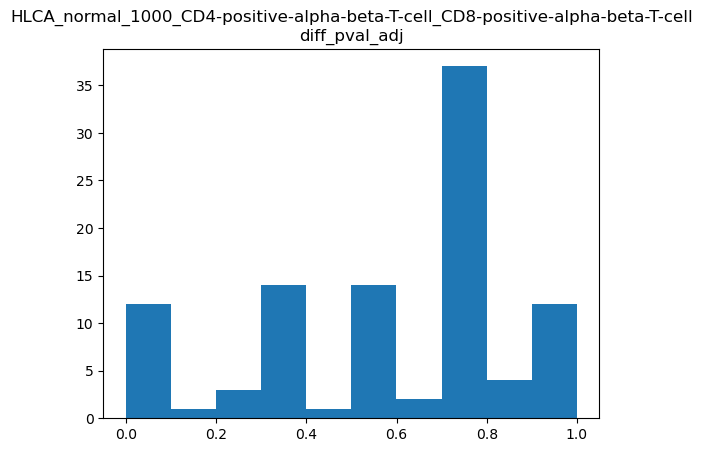

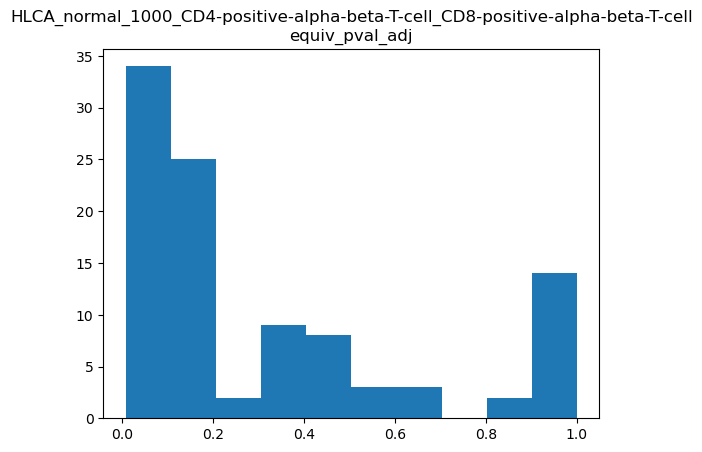

In [39]:
plt.hist(out_df["diff_pval_adj"])
plt.title("{}\ndiff_pval_adj".format(dataname))
plt.show()

plt.hist(out_df["equiv_pval_adj"])
plt.title("{}\nequiv_pval_adj".format(dataname))
plt.show()

In [40]:
out_df.sort_values("diff_pval_adj")

,gene,nnz_group1,nnz_group2,avg_group1,avg_group2,diff_pval,equiv_pval,diff_pval_adj,sig_diff,equiv_pval_adj,sig_equiv,sig_both
84,CD8A,78,247,0.296943,1.045055,4.199328e-35,1.000000,4.199328e-33,True,1.000000,False,False
96,PLEK,20,131,0.057483,0.407332,3.704208e-24,1.000000,1.852104e-22,True,1.000000,False,False
39,RGS1,273,162,1.225634,0.713235,6.426020e-11,1.000000,2.142007e-09,True,1.000000,False,False
95,NFKB2,72,25,0.191872,0.067383,5.731989e-06,0.997423,1.432997e-04,True,1.000000,False,False
19,PDE4B,120,65,0.354092,0.190121,2.157365e-05,0.998694,3.595608e-04,True,1.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
44,MYO19,12,14,0.032711,0.033424,9.587691e-01,0.000171,9.783359e-01,False,0.008573,True,False
4,NSD2,14,11,0.031487,0.030782,9.572966e-01,0.000103,9.783359e-01,False,0.008573,True,False
0,CERS4,21,19,0.047120,0.046318,9.581136e-01,0.000656,9.783359e-01,False,0.014065,True,False
52,YDJC,46,48,0.122234,0.121705,9.832927e-01,0.024584,9.932250e-01,False,0.091053,False,False


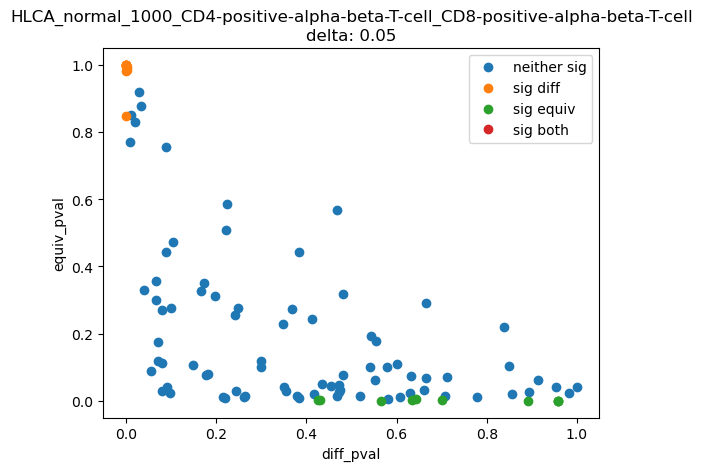

In [41]:

sub = out_df[(out_df["sig_diff"] == False) & (out_df["sig_equiv"] == False)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "neither sig")

sub = out_df[(out_df["sig_diff"] == True) & (out_df["sig_equiv"] == False)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig diff")

sub = out_df[(out_df["sig_diff"] == False) & (out_df["sig_equiv"] == True)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig equiv")

sub = out_df[(out_df["sig_diff"] == True) & (out_df["sig_equiv"] == True)]
plt.plot(sub["diff_pval"], sub["equiv_pval"],marker="o",linestyle="", label = "sig both")

plt.xlabel("diff_pval")
plt.ylabel("equiv_pval")
plt.title("{}\ndelta: {}".format(dataname,delta))
plt.legend()
plt.show()

In [42]:
print(dataname)
print("delta: {}".format(delta))
pd.crosstab(out_df['sig_equiv'], out_df['sig_diff']) 

HLCA_normal_1000_CD4-positive-alpha-beta-T-cell_CD8-positive-alpha-beta-T-cell
delta: 0.05


sig_diff,False,True
sig_equiv,,
False,80,10
True,10,0


In [23]:
test_df.groupby("cell_type")[gene].apply(list)

NameError: name 'test_df' is not defined

In [22]:
grouped_df = df.groupby("cell_type")


cell_type
CD4-positive, alpha-beta T cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
CD8-positive, alpha-beta T cell    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: CERS4, dtype: object

In [41]:
np.mean(samples[0])

0.04693597917086259